# Arnoldi iteration

Suppose $A\in\mathbb{C}^{m\times m}$ and $b\in\mathbb{C}^m$ are given. The $n$th **Krylov subspace** $\mathcal{K}_n$ is the range of a certain $m\times n$ matrix:

In [1]:
using LinearAlgebra
A = randn(500,500);
b = ones(500,1);
K = b;
n = 10;
for j = 1:n-1
    K = [K A*K[:,j]];
end

One way to think of $K$ is as keeping a history of all the vectors found in the power iteration. For that reason, we suspect that it may be rich in content with the leading eigenvectors of $A$, much as with simultaneous iteration. However, it's a poorly conditioned basis as $n$ grows, since the columns all become parallel to the leading eigenvector.

In [2]:
cond(K)

1.3004829638411992e12

We'd like a (thin) QR factorization of $K$, of course, but once $K$ has been put into floating point, the information about successive dimensions could be drawn out only through subtractive cancellation. Instead, there is a clever way to arrange the Gram-Schmidt process for this particular matrix.

Say $q_1,\ldots,q_j$ is an ONB for $\mathcal{K}_j$. By construction, $Aq_j\in \mathcal{K}_{j+1}$. Thus if $q_{j+1}$ extends the ONB to $\mathcal{K}_{j+1}$, it must be that

$$Aq_j = h_{1j} q_1 + \cdots + h_{nj} q_n + h_{j+1,j} q_{j+1}.$$

Furthermore, $h_{ij}=q_i^*Aq_j$. Written out for all $j=1,\ldots,n$, this implies 

$$AQ_n = Q_{n+1} \tilde{H}_n,$$

where $Q_j$ collects $q_1,\ldots,q_j$ and $\tilde{H}_n$ is an $(n+1)\times n$ upper Hessenberg matrix. Adapting the modified Gram-Schmidt algorithm, where the "new column" of a matrix comes from $A$ times the most recent column, we get the **Arnoldi iteration**.

In [3]:
function arnoldi(A,n)
    m = size(A,1)
    Q = zeros(m,n+1);
    H = zeros(n+1,n);
    Q[:,1] = b/norm(b);
    for j = 1:n
        v = A*Q[:,j]
        for i = 1:j
            H[i,j] = Q[:,i]'*v
            v = v - H[i,j]*Q[:,i]
        end
        H[j+1,j] = norm(v);
        Q[:,j+1] = v/H[j+1,j];
    end
    return H,Q
end

arnoldi (generic function with 1 method)

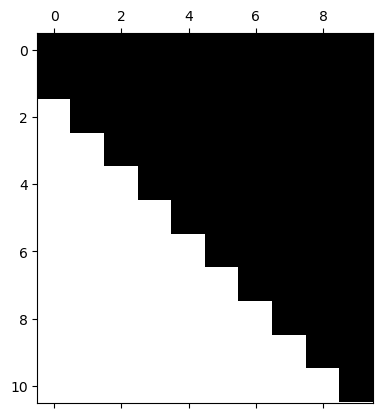

In [7]:
using PyPlot
H,Q = arnoldi(A,50)
spy(H[1:11,1:10]);

It's not hard to show that we can project $A$ into $\mathcal{K}_n$ (in the $Q_n$-basis) by 

$$Q_n^*AQ_n = Q_n^*Q_{n+1}\tilde{H}_n = H_n,$$

where $H_n$ is $\tilde{H}_n$ with the last row deleted. Eigenvalues of $H_n$ are eigenvalues of the action of $A$ as projected to $\mathcal{K}_n$. As $n\to\infty$, this begins to reveal some of the eigenvalues of $A$ itself. 

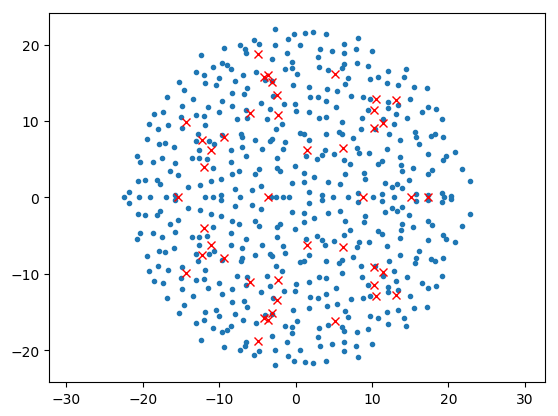

In [5]:
lam = eigvals(A);
plot(real(lam),imag(lam),".")
axis("square")
axis("equal")
for j = 5:n
    lam = eigvals(H[1:j,1:j]);
    plot(real(lam),imag(lam),"rx")
end

The big idea is to replace a problem on a very high-dimensional space, $\mathbb{C}^m$, with an approximating analog on a low-dimensional space, $\mathcal{K}_n$. For stability, this space is represented by means of an ON basis provided by the Arnoldi iteration.